<center><img src="https://github.com/hse-ds/iad-applied-ds/blob/master/2021/hw/hw1/img/logo_hse.png?raw=1" width="1000"></center>

<h1><center>Прикладные задачи анализа данных</center></h1>
<h2><center>Домашнее задание 4: Прогнозирование временных рядов</center></h2>

# Введение

В этом задании Вам предстоит разобраться с основами анализа и прогнозирования временных рядов. 


![image](https://imgs.xkcd.com/comics/extrapolating.png)

In [1]:
!pip install orbit-ml
!pip install prophet
!pip install sktime[all_extras]

  Using cached https://files.pythonhosted.org/packages/08/b9/b4f0938b38dbe775c4def707f525ab816b9d0215ecd8ab2d76780f4514f8/cmdstanpy-0.9.68-py3-none-any.whl
ERROR: fbprophet 0.7.1 has requirement cmdstanpy==0.9.5, but you'll have cmdstanpy 0.9.68 which is incompatible.
  Found existing installation: cmdstanpy 0.9.5
    Uninstalling cmdstanpy-0.9.5:
      Successfully uninstalled cmdstanpy-0.9.5
  Using cached https://files.pythonhosted.org/packages/e3/e2/204c9c6beaf9e05ad28bd589c154afff35dffa6166d76841d3c0dec6c1e3/cmdstanpy-0.9.5-py3-none-any.whl
ERROR: prophet 1.0.1 has requirement cmdstanpy==0.9.68, but you'll have cmdstanpy 0.9.5 which is incompatible.
  Found existing installation: cmdstanpy 0.9.68
    Uninstalling cmdstanpy-0.9.68:
      Successfully uninstalled cmdstanpy-0.9.68


In [2]:
%matplotlib inline

from IPython import display
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import datetime as dt

## Задание 1 (2 балла). Поиск и предобработка данных.

В этом задании Вам необходимо _самостоятельно_ найти два временных ряда: один должен обладать месячной частотой, а второй — дневной.

Мы советуем поискать соответствующие временные ряды на платформе [kaggle](https://www.kaggle.com/datasets) или же взять один из [популярных](https://medium.com/analytics-vidhya/10-time-series-datasets-for-practice-d14fec9f21bc) временных рядов для анализа. 

**Не рекоммендуется** использовать в качестве временных рядов цены финансовых инструментов в силу плохой предсказуемости изменения цен. **Запрещается** использовать готовые наборы данных из библиотек для анализа временных рядов, например, `from orbit.utils.dataset import load_iclaims`.

![bitcoin](https://avatars.mds.yandex.net/get-zen_doc/3417386/pub_6017dd4b8d30cb1780864ae0_6017f4aa8d30cb1780bf66ce/scale_1200)




В качестве отчета по заданию:

* Опишите источники временных рядов (ссылки на страницы скачивания). В случае, если данные требовали дополнительной обработки, приведите код этой обработки, загрузите данные в личное облачное хранилище и приведите ссылку на скачивание. Процесс получения временных рядов должен быть **четко** расписан и полностью **воспроизводиться**. 

* Приведите код считывания временных рядов из файлов и разделения на train/test. Соотношение размеров train/test на Ваше усмотрение, но мы советуем Вам выбрать 80% на 20%, если в test остаётся хотя бы пара лет наблюдений.



1. Этот набор данных содержит данные с 1 января 2013 г. по 24 апреля 2017 г. в городе Дели, Индия. Здесь четыре параметра:
средняя температура, влажность, скорость ветра, среднее давление . [dataset обладает дневной частотой (DailyDelhiClimate.csv)](https://www.kaggle.com/sumanthvrao/daily-climate-time-series-data)
2. Прогнозирование потребления электроэнергии в ближайшем будущем
[dataset обладает месячной частотой (Electric_Production.csv)](https://www.kaggle.com/kandij/electric-production)

In [3]:
# скачаем данные
!pip install gdown
!gdown https://drive.google.com/uc?id=1t2lHQ0mUARvDXCqWNyfbdv5kKjGY89Fa && unzip hw4_dataset.zip
!rm hw4_dataset.zip

Downloading...
From: https://drive.google.com/uc?id=1t2lHQ0mUARvDXCqWNyfbdv5kKjGY89Fa
To: /content/hw4_dataset.zip
100% 24.7k/24.7k [00:00<00:00, 23.2MB/s]
Archive:  hw4_dataset.zip
   creating: hw4_dataset/
  inflating: hw4_dataset/DailyDelhiClimateTest.csv  
  inflating: hw4_dataset/DailyDelhiClimateTrain.csv  
  inflating: hw4_dataset/Electric_Production.csv  


In [4]:
# считаем файлы
ts1 = pd.read_csv('hw4_dataset/Electric_Production.csv') #месячная частота
ts2_train = pd.read_csv('hw4_dataset/DailyDelhiClimateTrain.csv') #дневная частота
ts2_test =  pd.read_csv('hw4_dataset/DailyDelhiClimateTest.csv') #дневная частота

In [5]:
ts1

,DATE,Value
0,01-01-1985,72.5052
1,02-01-1985,70.6720
2,03-01-1985,62.4502
3,04-01-1985,57.4714
4,05-01-1985,55.3151
...,...,...
392,09-01-2017,98.6154
393,10-01-2017,93.6137
394,11-01-2017,97.3359
395,12-01-2017,114.7212


In [6]:
ts1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 397 entries, 0 to 396
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   DATE    397 non-null    object 
 1   Value   397 non-null    float64
dtypes: float64(1), object(1)
memory usage: 6.3+ KB


Переименуем столбцы и изменим типы колонок

In [7]:
ts1 = ts1.rename(columns={'DATE': 'date', 'Value': 'value'})
ts1['date'] = pd.to_datetime(ts1['date'])

In [8]:
ts1.date = pd.DatetimeIndex(ts1.date)


# Отсортируем и добавим date в индекс
ts1 = ts1.sort_values(by = "date")
ts1.index = pd.PeriodIndex(ts1.date, freq='M')

In [9]:
ts2_train.head()

,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000


In [10]:
ts2_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1462 entries, 0 to 1461
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   date          1462 non-null   object 
 1   meantemp      1462 non-null   float64
 2   humidity      1462 non-null   float64
 3   wind_speed    1462 non-null   float64
 4   meanpressure  1462 non-null   float64
dtypes: float64(4), object(1)
memory usage: 57.2+ KB


In [11]:
ts2_train['date'] = pd.to_datetime(ts2_train['date'])
ts2_test['date'] = pd.to_datetime(ts2_test['date'])

In [12]:
ts2_train.date = pd.DatetimeIndex(ts2_train.date)


# Отсортируем и добавим date в индекс
ts2_train = ts2_train.sort_values(by = "date")
ts2_train.index = pd.PeriodIndex(ts2_train.date, freq='D')

In [13]:
ts2_test.date = pd.DatetimeIndex(ts2_test.date)


# Отсортируем и добавим date в индекс
ts2_test = ts2_test.sort_values(by = "date")
ts2_test.index = pd.PeriodIndex(ts2_test.date, freq='D')

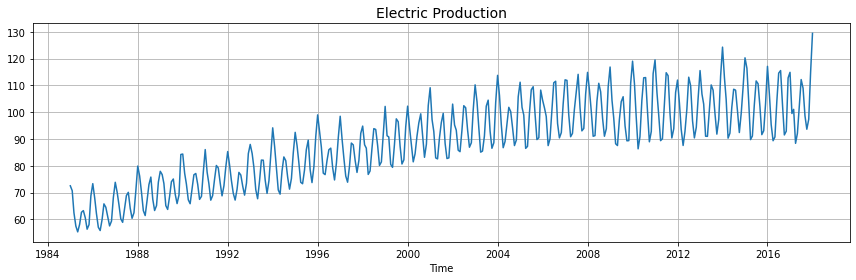

In [14]:
plt.figure(figsize=(12, 4))
plt.plot(ts1['date'].values, ts1['value'].values)
plt.xlabel('Time')
plt.title('Electric Production', size=14)
plt.grid(b=1)
plt.tight_layout()
plt.show()

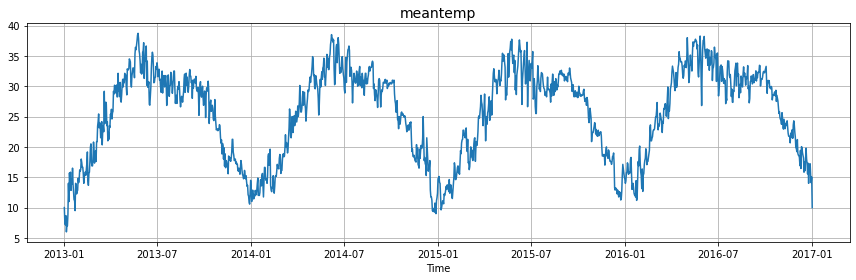

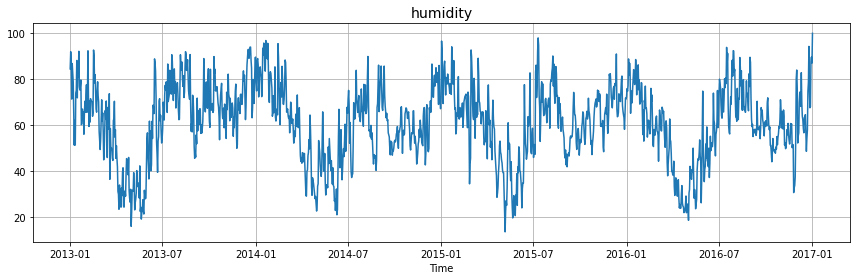

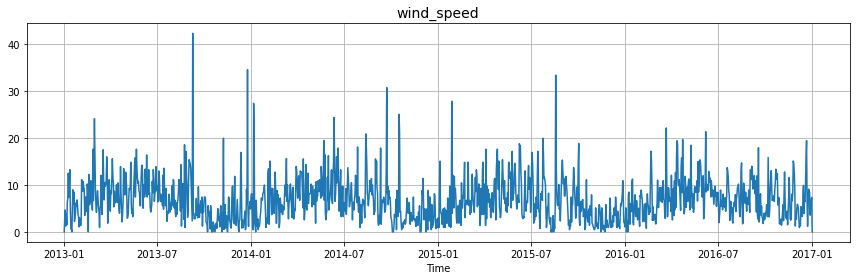

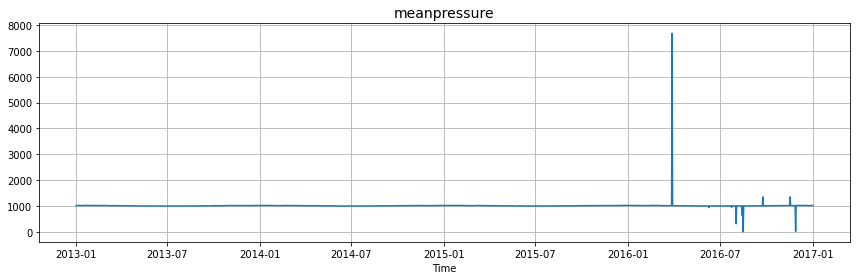

In [15]:
for fname in ts2_train.columns[1:]:
  plt.figure(figsize=(12, 4))
  plt.plot(ts2_train['date'].values, ts2_train[fname].values)
  plt.xlabel('Time')
  plt.title(fname, size=14)
  plt.grid(b=1)
  plt.tight_layout()
  plt.show()

In [16]:
# сделаем разбиение на train/test
# за нас уже ts2 разбили
from sktime.forecasting.model_selection import temporal_train_test_split
ts1_train, ts1_test = temporal_train_test_split(ts1, test_size=0.2)

## Задание 2. Анализ временных рядов (1 балла).

* Отрисуйте временные ряды и визуально сделайте различимым разбиение на выборки — либо вертикальной чертой, либо разными цветами.

* Постройте графики автокорреляционных функций для выбранных временных рядов. Прокомментируйте их: являются ли временные ряды сезонными? Видна ли на графиках длина сезонной составляющей ряда?

* В случае присутствия сезонности, разбейте временной ряд на повторяющиеся фрагменты и нарисуйте их наложенными для иллюстрации этой сезонности.

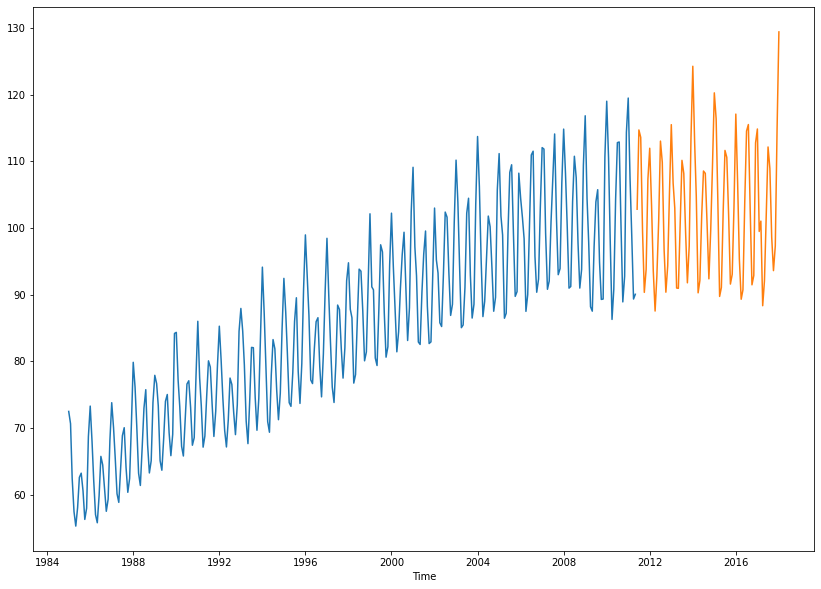

In [17]:
# отрисуем временные ряды
plt.figure(figsize=(14, 10))
plt.plot(ts1_train['date'].values, ts1_train['value'].values)
plt.plot(ts1_test['date'].values, ts1_test['value'].values)
plt.xlabel('Time')
plt.show()

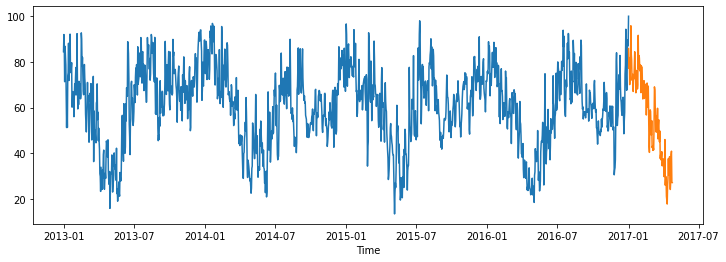

In [18]:
# отрисуем временные ряды
plt.figure(figsize=(12, 4))
plt.plot(ts2_train['date'].values, ts2_train['humidity'].values)
plt.plot(ts2_test['date'].values, ts2_test['humidity'].values)
plt.xlabel('Time')
plt.show()

In [19]:
from statsmodels.graphics.tsaplots import plot_acf


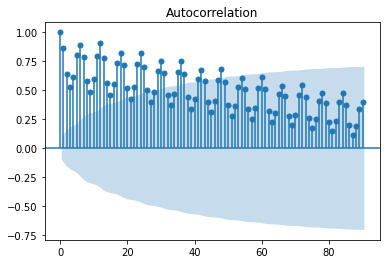

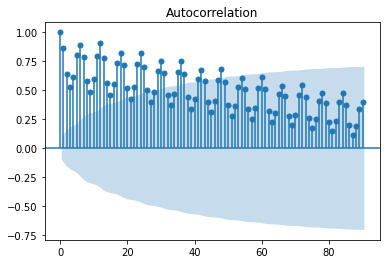

In [20]:
plot_acf(ts1['value'], lags=90)

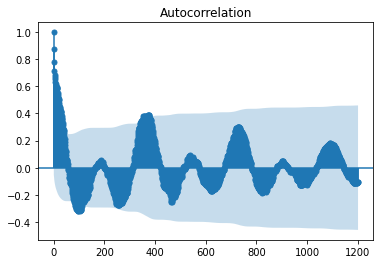

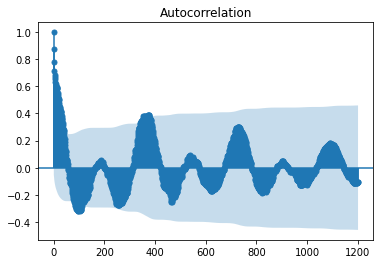

In [21]:
plot_acf(ts2_train['humidity'], lags=1200)

In [25]:
ts1['year'] = ts1['date'].dt.year
start = min(ts1.year)
end = max(ts1.year)

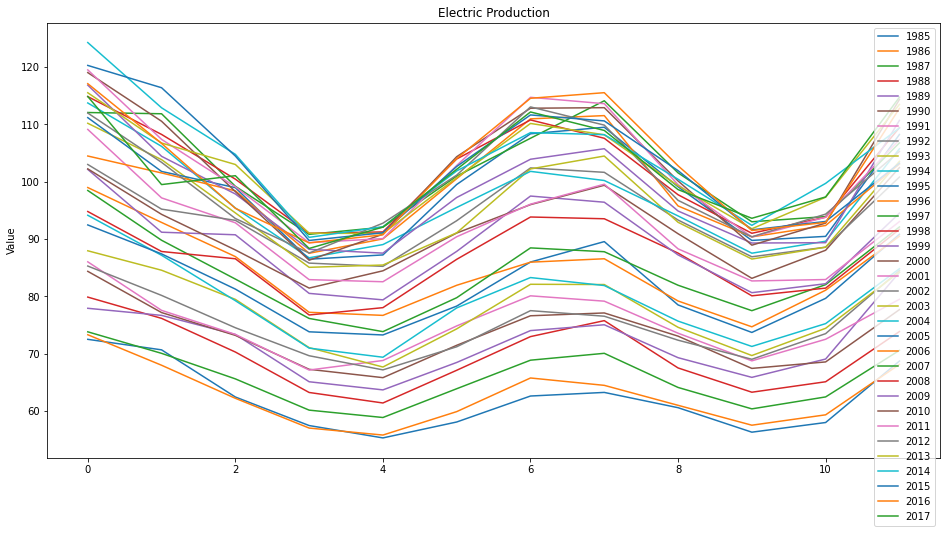

In [30]:
plt.figure(figsize=(16, 8))
for year in range(start, end):
  plt.plot(range(len(ts1.query('year == @year')['date'])), ts1.query('year == @year')['value'], label=f'{year}')
plt.ylabel('Value')
plt.legend(loc='upper right')
plt.title('Electric Production')
plt.show()

In [32]:
ts2_train['year'] = ts2_train['date'].dt.year
start = min(ts2_train.year)
end = max(ts2_train.year)

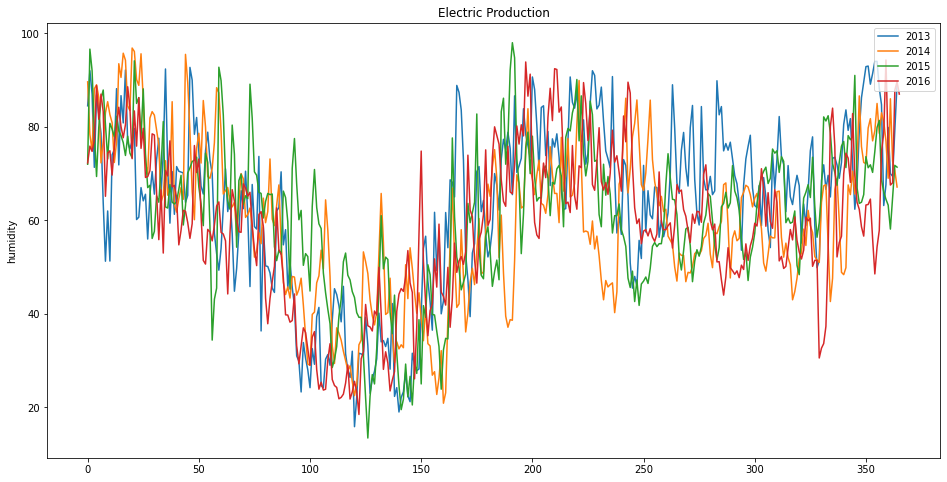

In [34]:
plt.figure(figsize=(16, 8))
for year in range(start, end):
  plt.plot(range(len(ts2_train.query('year == @year')['date'])), ts2_train.query('year == @year')['humidity'], label=f'{year}')
plt.ylabel('humidity')
plt.legend(loc='upper right')
plt.title('Electric Production')
plt.show()

In [35]:
ts2_train = ts2_train.drop(['year'], axis=1)
ts1 = ts1.drop(['year'], axis=1)

## Задание 3. Предсказание месячного временного ряда (4.5 балла).

В этом задании Вам предстоит попробовать предсказать месячный временной несколькими готовыми моделями со скользящим или растущим окном и выбрать среди них наилучшую.

В качестве метрики сравнения используйте MAE между истинными и предсказанными значениями ряда на тестовом отрезке.


### NaiveForecaster из sktime (0.5 балл).

Посчитайте предсказания следующими двумя наивными способами:

* $\hat{y}_{t+1} = y_{t}$
* $\hat{y}_{t+1} = y_{t-seasonality+1}$

In [36]:
from sktime.forecasting.naive import NaiveForecaster
from sklearn.metrics import mean_absolute_error
from sktime.forecasting.base import ForecastingHorizon
from sktime.utils.plotting import plot_series



In [37]:
y_test_plot = ts1_test.drop(['date'], axis = 1).squeeze()
y_train_plot = ts1_train.drop(['date'], axis = 1).squeeze()

In [38]:
# ваш код обучения моделей здесь
naive_forecaster = NaiveForecaster()
naive_forecaster.fit(ts1_train['value'])

NaiveForecaster()

In [39]:
# посчитайте метрики на test
fh = ForecastingHorizon(ts1_test.index, is_relative=False)
naive_forecaster_predict = naive_forecaster.predict(fh)
print("NaiveForecaster sp = 1 MAE: {:.4f}".format(mean_absolute_error(ts1_test['value'], naive_forecaster_predict)))

NaiveForecaster sp = 1 MAE: 12.7812


(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='value'>)

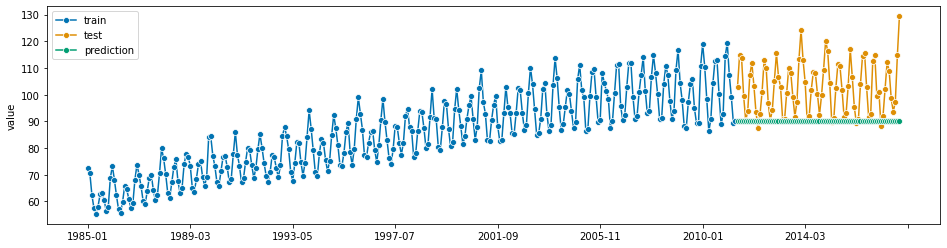

In [40]:
plot_series(y_train_plot, y_test_plot, naive_forecaster_predict, labels=["train", "test", "prediction"])

In [41]:
naive_forecaster_12 = NaiveForecaster(sp=12)
naive_forecaster_12.fit(ts1_train['value'])

NaiveForecaster(sp=12)

In [42]:
naive_forecaster_predict_12 = naive_forecaster_12.predict(fh)
print("NaiveForecaster sp = 12 MAE: {:.4f}".format(mean_absolute_error(ts1_test['value'], naive_forecaster_predict_12)))

NaiveForecaster sp = 12 MAE: 2.9626


(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='value'>)

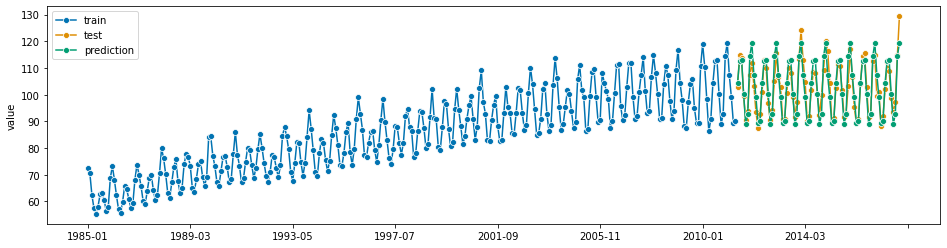

In [43]:
plot_series(y_train_plot, y_test_plot, naive_forecaster_predict_12, labels=["train", "test", "prediction"])

### ARIMA/AutoArima (1 балл).

Обучите из библиотеки `sktime` модели:

* SARIMA(1, 1, 1)(1, 0, 0)[12] (`ARIMA` в `sktime`)
* Алгоритм Хиндмана-Хандакара подбора SARIMA (`AutoARIMA` в `sktime`)

In [44]:
from sktime.forecasting.arima import ARIMA, AutoARIMA
arima = ARIMA(order=(1, 1, 1), seasonal_order=(1, 0, 0, 12))
arima.fit(ts1_train['value'])

ARIMA(order=(1, 1, 1), seasonal_order=(1, 0, 0, 12))

In [45]:
arima_predict = arima.predict(fh)
print("Arima MAE: {:.4f}".format(mean_absolute_error(ts1_test['value'], arima_predict)))

Arima MAE: 6.6065


(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='value'>)

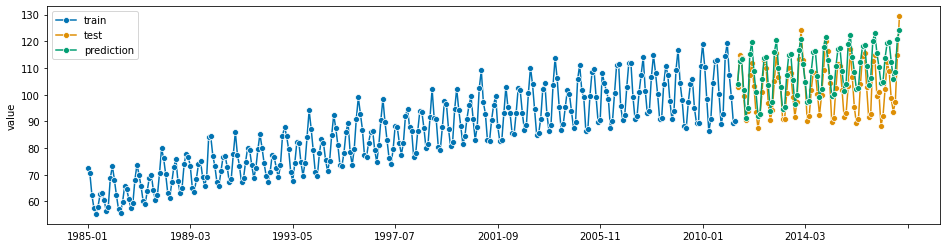

In [46]:
plot_series(y_train_plot, y_test_plot, arima_predict, labels=["train", "test", "prediction"])

In [47]:
autoarima = AutoARIMA(sp=12)
autoarima.fit(ts1_train['value'])

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.7/

AutoARIMA(sp=12)

In [48]:
auto_arima_pred = autoarima.predict(fh)
print("Auto Arima MAE: {:.4f}".format(mean_absolute_error(ts1_test['value'], auto_arima_pred)))

Auto Arima MAE: 6.6882


(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='value'>)

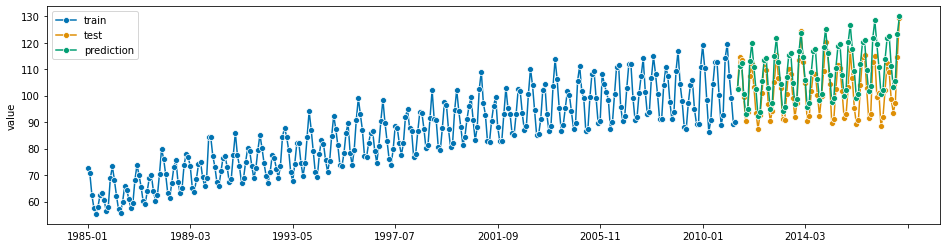

In [49]:
plot_series(y_train_plot, y_test_plot, auto_arima_pred, labels=["train", "test", "prediction"])

### LGT/DLT (1 балл).

Обучите из библиотеки `orbit` модели LGT и DLT

In [50]:
from orbit.models.lgt import LGTFull
from orbit.models.dlt import DLTFull


In [51]:
lgt = LGTFull(response_col='value', date_col='date', seasonality=12)
lgt.fit(ts1_train)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_2af9ff5e07f97061bbe4badb0f8a2e36 NOW.
To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [52]:
lgt_predict = lgt.predict(ts1_test)
print("LGT MAE: {:.4f}".format(mean_absolute_error(ts1_test['value'], lgt_predict['prediction'])))

LGT MAE: 4.9781


In [53]:
lgt_predict.index = y_test_plot.index

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='value'>)

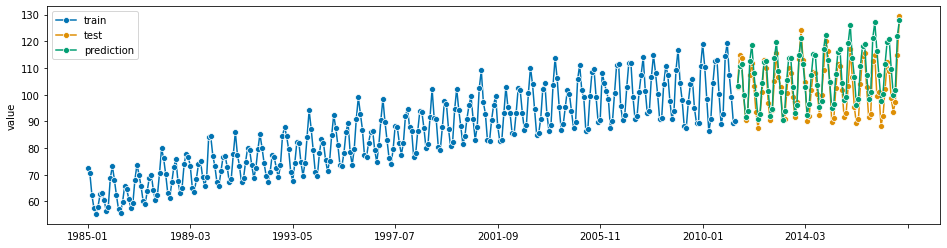

In [54]:
plot_series(y_train_plot, y_test_plot, lgt_predict['prediction'], labels=["train", "test", "prediction"])

In [55]:
dlt = DLTFull(response_col='value', date_col='date', seasonality=12)
dlt.fit(ts1_train)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_b0a449c7523386cce384e92a998e71c8 NOW.
To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [56]:
dlt_predict =  dlt.predict(ts1_test)
print("DLT MAE: {:.4f}".format(mean_absolute_error(ts1_test['value'],dlt_predict['prediction'])))

DLT MAE: 4.0695


In [57]:
dlt_predict.index = y_test_plot.index

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='value'>)

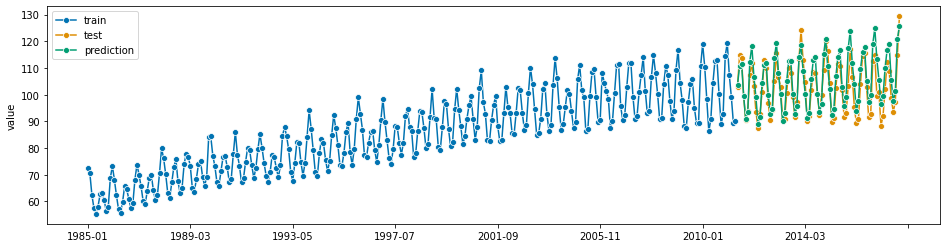

In [58]:
plot_series(y_train_plot, y_test_plot, dlt_predict['prediction'], labels=["train", "test", "prediction"])

### ETS (2 балла).

Обучите из библиотеки `sklearn` модели:

* ETS(AAA) (`ExponentialSmoothing` в `sktime`)
* ETS с автоматическим выбором по AIC (`AutoETS` в `sktime`)

In [59]:
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.forecasting.ets import AutoETS

# ваш код обучения моделей здесь

In [60]:
exponential_smoothing = ExponentialSmoothing(sp=12)
exponential_smoothing.fit(ts1_train['value'])

ExponentialSmoothing(sp=12)

In [61]:
exponential_smoothing_predict = exponential_smoothing.predict(fh)
print("Exponential Smoothing MAE: {:.4f}".format(mean_absolute_error(ts1_test['value'], exponential_smoothing_predict)))

Exponential Smoothing MAE: 12.7813


(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='value'>)

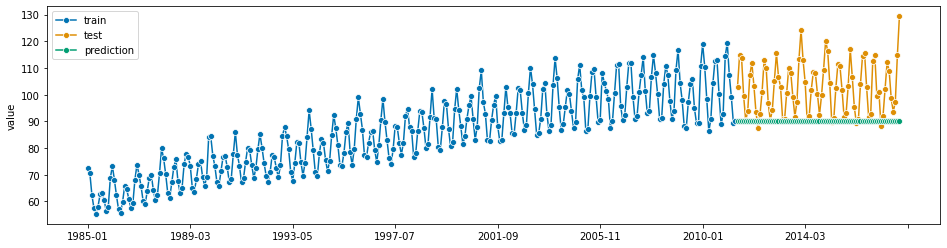

In [62]:
plot_series(y_train_plot, y_test_plot, exponential_smoothing_predict, labels=["train", "test", "prediction"])

In [63]:
auto_ets = AutoETS(sp=12)
auto_ets.fit(ts1_train['value'])

AutoETS(sp=12)

In [64]:
auto_ets_predict = auto_ets.predict(fh)
print("AutoETS MAE: {:.4f}".format(mean_absolute_error(ts1_test['value'], auto_ets_predict)))

AutoETS MAE: 8.1473


(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='value'>)

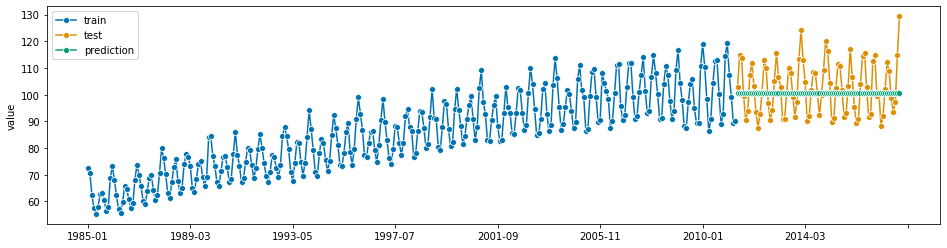

In [65]:
plot_series(y_train_plot, y_test_plot, auto_ets_predict, labels=["train", "test", "prediction"])

Нарисуйте для наилучшей модели предсказания с доверительным интервалом (если модель выдает его) и наложите их на истинные значения. В `sktime` `ETS` модель пока ещё не выдаёт доверительные интервалы, но при желании до них можно дотянуться :)

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='value'>)

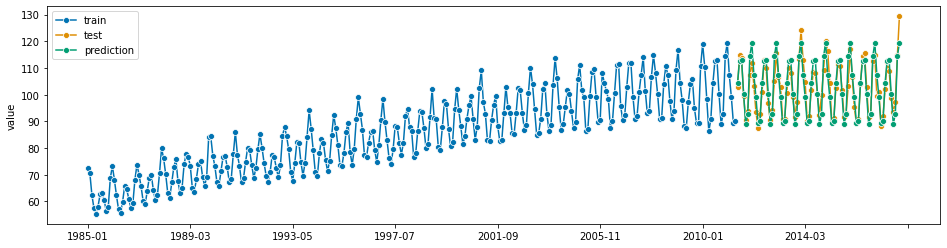

In [66]:
plot_series(y_train_plot, y_test_plot, naive_forecaster_predict_12, labels=["train", "test", "prediction"])

## Задание 4. Предсказание дневного временного ряда (2.5 балла).

В этом задании Вам предстоит попробовать предсказать выбранный Вами дневной временной ряд.

Аналогично, в качестве метрики используем MAE.



### NaiveForecaster из sktime (0.5 балла).

Посчитайте предсказания следующими двумя наивными способами:

* $\hat{y}_{t+1} = y_{t}$
* $\hat{y}_{t+1} = y_{t-seasonality+1}$

In [67]:
y_train_daily_plot = ts2_train.drop(['date', 'meantemp', 'wind_speed', 'meanpressure'], axis=1).squeeze()
y_test_daily_plot = ts2_test.drop(['date', 'meantemp', 'wind_speed', 'meanpressure'], axis=1).squeeze()

In [68]:
from sktime.forecasting.naive import NaiveForecaster

daily_naive_forecaster = NaiveForecaster()
daily_naive_forecaster.fit(ts2_train['humidity'])

NaiveForecaster()

In [69]:
fh = ForecastingHorizon(ts2_test.index, is_relative=False)
daily_naive_forecaster_predict = daily_naive_forecaster.predict(fh)
print("NaiveForecaster sp=1 MAE: {:.4f}".format(mean_absolute_error(ts2_test['humidity'], daily_naive_forecaster_predict)))

NaiveForecaster sp=1 MAE: 43.6276


(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='humidity'>)

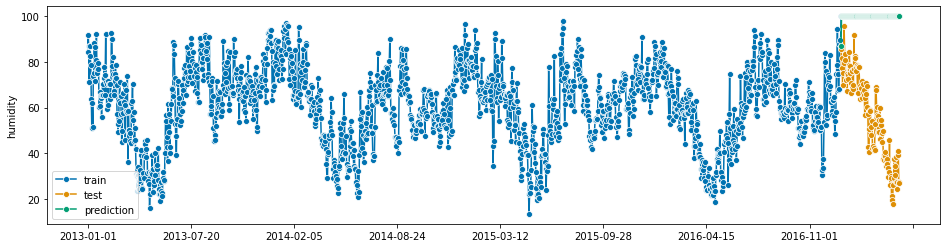

In [70]:
plot_series(y_train_daily_plot, y_test_daily_plot, daily_naive_forecaster_predict, labels=["train", "test", "prediction"])

In [71]:
daily_naive_forecaster_365 = NaiveForecaster(sp=365)
daily_naive_forecaster_365.fit(ts2_train['humidity'])

NaiveForecaster(sp=365)

In [72]:
daily_naive_forecaster_365_predict = daily_naive_forecaster_365.predict(fh)
print("NaiveForecaster sp=365 MAE: {:.4f}".format(mean_absolute_error(ts2_test['humidity'], daily_naive_forecaster_365_predict)))

NaiveForecaster sp=365 MAE: 8.9093


(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='humidity'>)

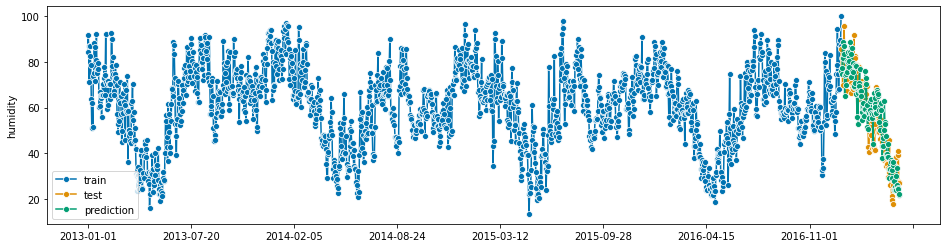

In [73]:
plot_series(y_train_daily_plot, y_test_daily_plot, daily_naive_forecaster_365_predict, labels=["train", "test", "prediction"])

### KTR из orbit (1 балл).



In [74]:
from orbit.models.ktrlite import KTRLiteMAP

ktr_lite_map = KTRLiteMAP(date_col='date', response_col='humidity', seasonality = 365 )
ktr_lite_map.fit(ts2_train)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_54eae5ecf2d426f33baa7b746b329122 NOW.


In [75]:
ktr_lite_map_predict = ktr_lite_map.predict(ts2_test)
print("KTRLiteMAP MAE: {:.4f}".format(mean_absolute_error(ts2_test['humidity'], ktr_lite_map_predict['prediction'])))

KTRLiteMAP MAE: 7.3295


In [76]:
pred = ktr_lite_map_predict['prediction']
pred.index = y_test_daily_plot.index

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='humidity'>)

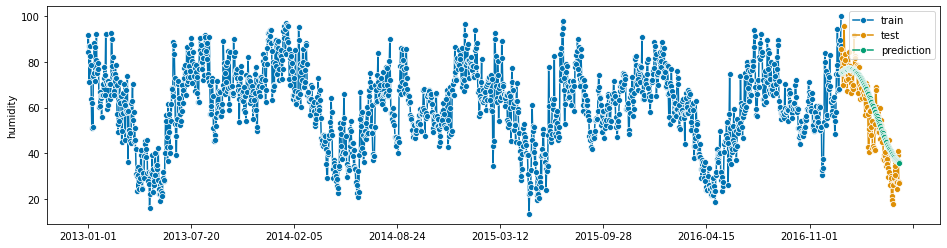

In [77]:
plot_series(y_train_daily_plot, y_test_daily_plot, pred, labels=["train", "test", "prediction"])

### Phophet (1 балл).



In [78]:
ts2_prophet_train = ts2_train[['date', 'meantemp', 'humidity', 'wind_speed', 'meanpressure']]
ts2_prophet_train.columns = ['ds', 'meantemp', 'y', 'wind_speed', 'meanpressure']
ts2_prophet_train.head()

,ds,meantemp,y,wind_speed,meanpressure
date,,,,,
2013-01-01,2013-01-01,10.000000,84.500000,0.000000,1015.666667
2013-01-02,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2013-01-03,2013-01-03,7.166667,87.000000,4.633333,1018.666667
2013-01-04,2013-01-04,8.666667,71.333333,1.233333,1017.166667
2013-01-05,2013-01-05,6.000000,86.833333,3.700000,1016.500000


In [79]:
ts2_prophet_test = ts2_test[['date', 'meantemp', 'humidity', 'wind_speed', 'meanpressure']]
ts2_prophet_test.columns = ['ds', 'meantemp', 'y', 'wind_speed', 'meanpressure']

In [80]:
from prophet import Prophet

prophet = Prophet()
prophet.add_regressor('meantemp')
prophet.add_regressor('wind_speed')

In [81]:
prophet.fit(ts2_prophet_train)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [82]:
prophet_predict = prophet.predict(ts2_prophet_test)
prophet_predict = prophet_predict.set_index('ds')
print("Prophet MAE: {:.4f}".format(mean_absolute_error(ts2_prophet_test['y'], prophet_predict['yhat'])))

Prophet MAE: 11.5645


In [84]:
prophet_pred = prophet_predict['yhat']
prophet_pred.index = y_test_daily_plot.index

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='humidity'>)

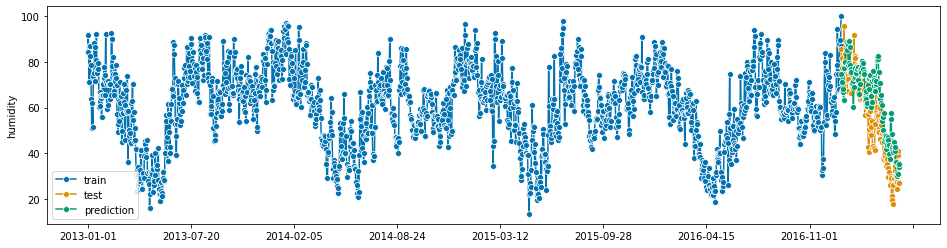

In [85]:
plot_series(y_train_daily_plot, y_test_daily_plot, prophet_pred, labels=["train", "test", "prediction"])

Нарисуйте для наилучшей модели предсказания с доверительным интервалом (если модель выдает его) и наложите их на истинные значения.

In [86]:
ktr_lite_map_predict = ktr_lite_map.predict(ts2_test)
print("KTRLiteMAP MAE: {:.4f}".format(mean_absolute_error(ts2_test['humidity'], ktr_lite_map_predict['prediction'])))

KTRLiteMAP MAE: 7.3295


In [88]:
from orbit.diagnostics.plot import plot_predicted_data

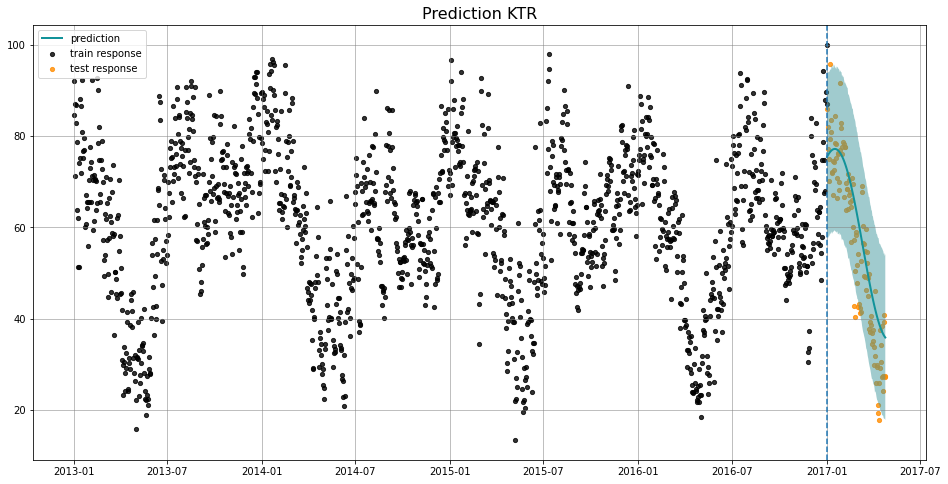

In [93]:
_ = plot_predicted_data(training_actual_df=ts2_train, predicted_df=ktr_lite_map_predict,
                        date_col='date', actual_col='humidity',
                        test_actual_df=ts2_test, title='Prediction KTR')